In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

from pprint import pprint

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston

%matplotlib inline

In [2]:
from sklearn import base
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from xgboost import XGBRegressor

### Load the data

In [3]:
boston = load_boston()

In [4]:
pprint (boston)

{'DESCR': '.. _boston_dataset:\n'
          '\n'
          'Boston house prices dataset\n'
          '---------------------------\n'
          '\n'
          '**Data Set Characteristics:**  \n'
          '\n'
          '    :Number of Instances: 506 \n'
          '\n'
          '    :Number of Attributes: 13 numeric/categorical predictive. '
          'Median Value (attribute 14) is usually the target.\n'
          '\n'
          '    :Attribute Information (in order):\n'
          '        - CRIM     per capita crime rate by town\n'
          '        - ZN       proportion of residential land zoned for lots '
          'over 25,000 sq.ft.\n'
          '        - INDUS    proportion of non-retail business acres per '
          'town\n'
          '        - CHAS     Charles River dummy variable (= 1 if tract '
          'bounds river; 0 otherwise)\n'
          '        - NOX      nitric oxides concentration (parts per 10 '
          'million)\n'
          '        - RM       average num

In [5]:
print (boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['HomePrice'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,HomePrice
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


### Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CRIM       506 non-null    float64
 1   ZN         506 non-null    float64
 2   INDUS      506 non-null    float64
 3   CHAS       506 non-null    float64
 4   NOX        506 non-null    float64
 5   RM         506 non-null    float64
 6   AGE        506 non-null    float64
 7   DIS        506 non-null    float64
 8   RAD        506 non-null    float64
 9   TAX        506 non-null    float64
 10  PTRATIO    506 non-null    float64
 11  B          506 non-null    float64
 12  LSTAT      506 non-null    float64
 13  HomePrice  506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


#### Count missing values in each column 

In [8]:
df.isna().sum(axis=0)

CRIM         0
ZN           0
INDUS        0
CHAS         0
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
HomePrice    0
dtype: int64

There are no null values in the data.

#### Distribution of features and response variables

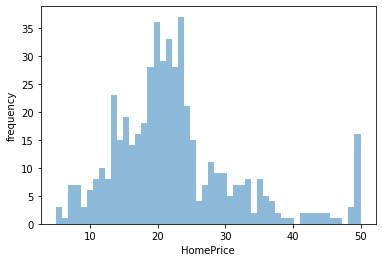

In [9]:
df['HomePrice'].hist(bins=50, alpha=0.5, grid=False)
plt.xlabel('HomePrice')
plt.ylabel('frequency');

In [10]:
def feature_distribution_plots(df, feature_names, plot_grid=None):
    if not plot_grid:
        ncols = 3
        nrows = math.ceil(len(feature_names)/ncols)
    else:
        nrows, ncols = plot_grid
        
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))
    axes = axes.reshape(-1, ncols)  # Make sure axes is a 2D array

    for k, feat in enumerate(boston.feature_names):
        i, j = divmod(k, ncols)
        ax = axes[i][j]
        df[feat].plot.hist(bins=50, alpha=0.5, ax=ax)
        ax.set_xlabel(feat)
        ax.set_ylabel('frequency')
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    # Remove emplty subplots
    for k in range(len(feature_names), nrows*ncols):
        fig.delaxes(axes.flatten()[k])      

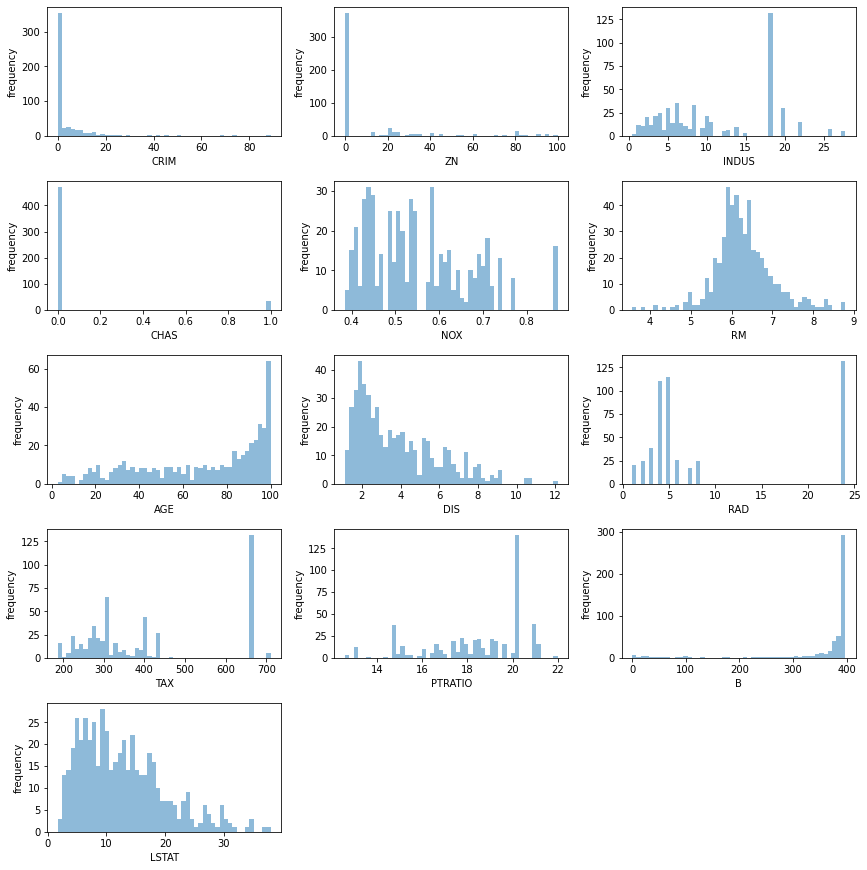

In [11]:
feature_distribution_plots(df, boston.feature_names)

In [12]:
def feature_target_scatterplots(df, feature_names, target_name, plot_grid=None):
    if not plot_grid:
        ncols = 3
        nrows = math.ceil(len(feature_names)/ncols)
    else:
        nrows, ncols = plot_grid
        
    fig, axes = plt.subplots(nrows, ncols, figsize=(12,12))
    axes = axes.reshape(-1, ncols)  # Make sure axes is a 2D array

    for k, feat in enumerate(boston.feature_names):
        i, j = divmod(k, ncols)
        ax = axes[i][j]
        df.plot.scatter(x=feat, y=target_name, alpha=0.5, ax=ax)
        ax.set_xlabel(feat)
        ax.set_ylabel(target_name)
        
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    
    # Remove emplty subplots
    for k in range(len(feature_names), nrows*ncols):
        fig.delaxes(axes.flatten()[k])  

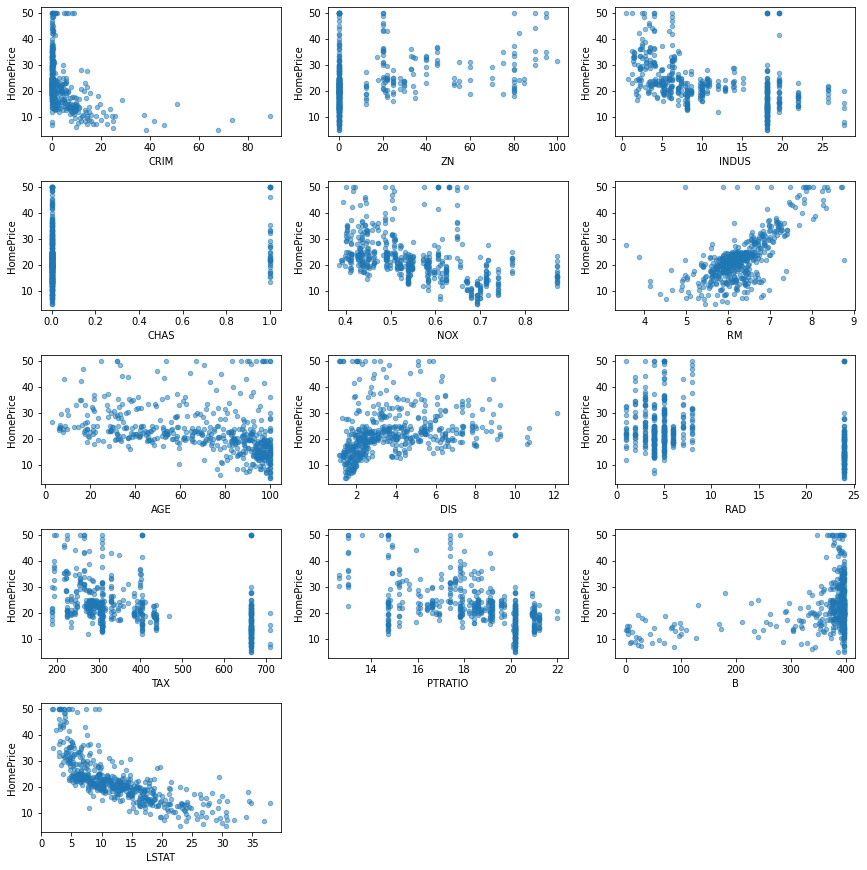

In [13]:
feature_target_scatterplots(df, boston.feature_names, 'HomePrice', plot_grid=None)    

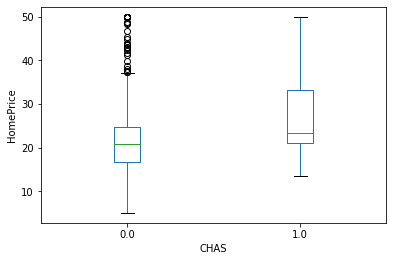

In [14]:
df.boxplot(column='HomePrice', by='CHAS', grid=False)
plt.ylabel('HomePrice')
plt.suptitle('')
plt.title('');

#### Derived features

In [15]:
# Derived numerical features
df['INV_CRIM'] = 1.0/df['CRIM']
df['INV_NOX'] = 1.0/df['NOX']
df['INV_LTSAT'] = 1.0/df['LSTAT']

# Derived categorical features
df['INDUS_LE_7'] = 1.0*(df['INDUS'] <= 7)
df['INDUS_LE_16'] = 1.0*(df['INDUS'] <= 16)
df['AGE_LE_75'] = 1.0*(df['AGE'] <= 75)
df['RAD_LE_10'] = 1.0*(df['RAD'] <= 10)
df['TAX_LE_500'] = 1.0*(df['TAX'] <= 500)
df['PTRATIO_LE_19'] = 1.0*(df['PTRATIO'] <= 19)
df['B_LE_350'] = 1.0*(df['B'] <= 350)

In [16]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,...,INV_CRIM,INV_NOX,INV_LTSAT,INDUS_LE_7,INDUS_LE_16,AGE_LE_75,RAD_LE_10,TAX_LE_500,PTRATIO_LE_19,B_LE_350
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,...,158.227848,1.858736,0.200803,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,...,36.616624,2.132196,0.109409,0.0,1.0,0.0,1.0,1.0,1.0,0.0
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,...,36.643459,2.132196,0.248139,0.0,1.0,1.0,1.0,1.0,1.0,0.0
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,...,30.892802,2.183406,0.340136,1.0,1.0,1.0,1.0,1.0,1.0,0.0
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,...,14.482259,2.183406,0.187617,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [17]:
numerical_features = [
    'CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 
    'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT',
    'INV_CRIM', 'INV_NOX', 'INV_LTSAT'
]

categorical_features = [
    'CHAS',
    'INDUS_LE_7', 'INDUS_LE_16', 'AGE_LE_75', 'RAD_LE_10', 
    'TAX_LE_500', 'PTRATIO_LE_19', 'B_LE_350'
]

In [18]:
# Reorder columns. All numerical features followed by all categorical features follwed by the target column.
feature_names = numerical_features + categorical_features
df = df[feature_names + ['HomePrice']]
df.head()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,...,INV_LTSAT,CHAS,INDUS_LE_7,INDUS_LE_16,AGE_LE_75,RAD_LE_10,TAX_LE_500,PTRATIO_LE_19,B_LE_350,HomePrice
0,0.00632,18.0,2.31,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,...,0.200803,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,24.0
1,0.02731,0.0,7.07,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,...,0.109409,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,21.6
2,0.02729,0.0,7.07,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,...,0.248139,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,34.7
3,0.03237,0.0,2.18,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,...,0.340136,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,33.4
4,0.06905,0.0,2.18,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,...,0.187617,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,36.2


#### Correlation between numerical features

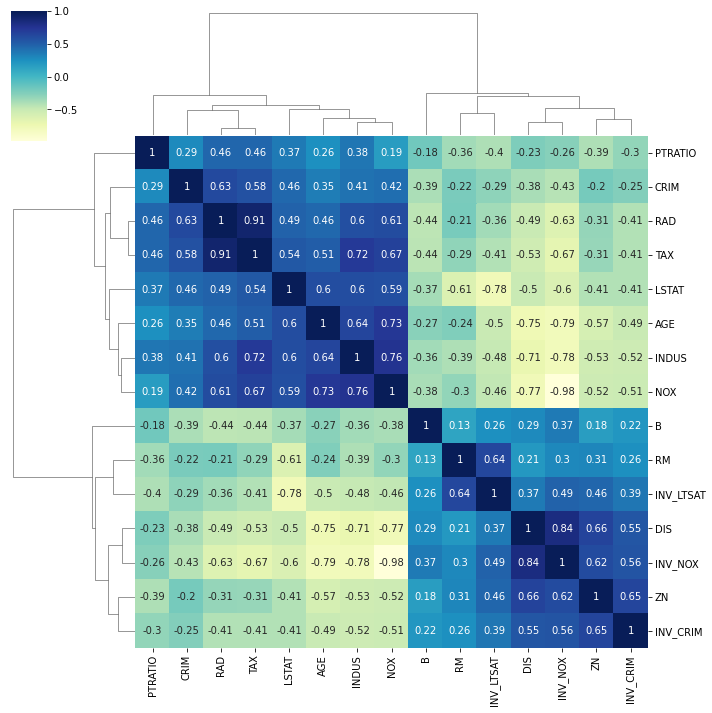

In [19]:
corr = df[numerical_features].dropna().corr()
# corr.style.background_gradient(cmap='YlGnBu', axis=None).set_precision(2)
sns.clustermap(corr, cmap ="YlGnBu", annot=True, figsize=(10,10));

#### Correlation between categorical features
https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9  
https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792

In [20]:
def cramers_v(categorical_features):
    def pair_cramers_v(confusion_matrix):
        """ calculate Cramers V statistic for categorial-categorial association.
            uses correction from Bergsma and Wicher,
            Journal of the Korean Statistical Society 42 (2013): 323-328
        """
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
    
    cramer_v_df = pd.DataFrame(columns=categorical_features, index=categorical_features).astype(np.float)
    for feat1 in categorical_features:
        for feat2 in categorical_features:
            cramer_v_df[feat1][feat2] = pair_cramers_v(pd.crosstab(df[feat1], df[feat2]).values)
    return cramer_v_df

In [21]:
cramer_v_df = cramers_v(categorical_features)

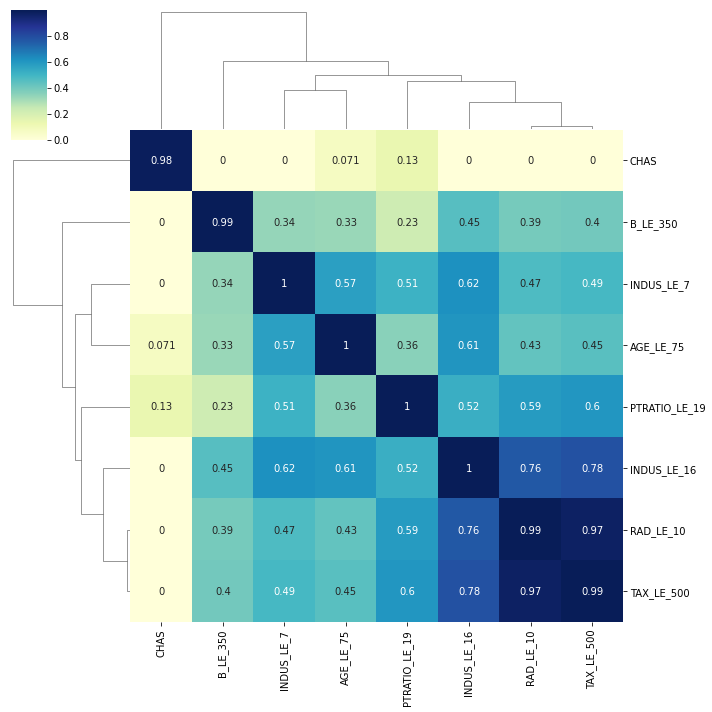

In [22]:
sns.clustermap(cramer_v_df, cmap ="YlGnBu", annot=True, figsize=(10,10));

In [23]:
class ColumnSelector(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.columns]

In [24]:
numericalFeatureTransformer = Pipeline([
    ('column_selector', ColumnSelector(columns=numerical_features)),
    ('scaler', StandardScaler())
])

categoricalFeatureTransformer = Pipeline([
    ('column_selector', ColumnSelector(columns=categorical_features))
])

#numericalFeatureTransformer.fit_transform(df)
#categoricalFeatureTransformer.fit_transform(df)

In [25]:
allFeatureTransformers = FeatureUnion([
    ('num', numericalFeatureTransformer),
    ('cat', categoricalFeatureTransformer)
])

#allFeatureTransformers.fit_transform(df)

In [26]:
X = df.drop(labels=['HomePrice'], axis=1)
y = df['HomePrice']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((404, 23), (404,), (102, 23), (102,))

In [29]:
def compute_cv_metrics(model, X, y):
    # Mean squared error
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
    errors = -cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')
    #print (errors)
    # R-squared score
    r2_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    #print (r2)    
    return {
        'mean_squared_error': errors.mean(), 
        'R2_score': r2_scores.mean()
    }

In [30]:
def get_permutation_importance(est, feature_names, X, y, n_repeats=10):
    # Source: https://scikit-learn.org/stable/modules/permutation_importance.html
    
    r = permutation_importance(est, X, y, n_repeats=n_repeats, random_state=42)    
    df = pd.DataFrame(columns=['feature_name', 'importance_mean', 'importance_std'])
    for i in r.importances_mean.argsort()[::-1]:
        if True: #r.importances_mean[i] - 2 * r.importances_std[i] > 0:
            df = df.append(
                pd.Series([feature_names[i], r.importances_mean[i], r.importances_std[i]], index=df.columns),
                ignore_index=True
            )    
    return df

### Linear regression

In [31]:
lin_reg = Pipeline([
    ('preprocessor', allFeatureTransformers),
    ('lin_reg', LinearRegression())    
])

In [32]:
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('num',
                                                 Pipeline(steps=[('column_selector',
                                                                  ColumnSelector(columns=['CRIM',
                                                                                          'ZN',
                                                                                          'INDUS',
                                                                                          'NOX',
                                                                                          'RM',
                                                                                          'AGE',
                                                                                          'DIS',
                                                                                          'RAD',
                                                 

In [33]:
print ("R-squared: {:.2f}".format(r2_score(lin_reg.predict(X_train), y_train)))
print ("R-squared: {:.2f}".format(r2_score(lin_reg.predict(X_test), y_test)))

R-squared: 0.77
R-squared: 0.72


In [34]:
cv_metrics = compute_cv_metrics(lin_reg, X_train, y_train)
print ("Mean squared error: {:.2f}".format(cv_metrics['mean_squared_error']))
print ("R2_score: {:.2f}".format(cv_metrics['R2_score']))

Mean squared error: 19.04
R2_score: 0.77


#### Feature importance

In [35]:
importance = lin_reg.named_steps.lin_reg.coef_

In [36]:
feat_imp_df = pd.DataFrame(columns=['feature_name', 'importance'])
for (feat, imp) in sorted(zip(feature_names, importance), key = lambda x: x[1], reverse=True):
    feat_imp_df = feat_imp_df.append(
        pd.Series([feat, imp], index=feat_imp_df.columns), ignore_index=True
    )    
    
feat_imp_df

,feature_name,importance
0,RAD_LE_10,10.921735
1,RAD,3.858061
2,INV_LTSAT,3.481231
3,CHAS,2.465564
4,RM,2.197241
5,B,1.406968
6,B_LE_350,1.302539
7,AGE_LE_75,0.328489
8,ZN,0.088270
9,INV_CRIM,-0.018399


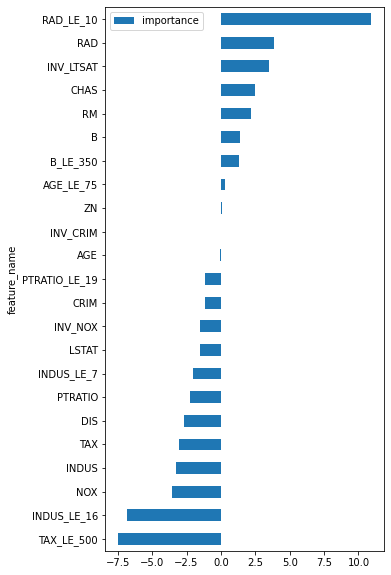

In [37]:
feat_imp_df.sort_values(by=['importance']).plot.barh(x='feature_name', y='importance', figsize=(5, 10));

The feature importances of some of the variables such as RAD, TAX, RAD_LE_10, TAX_LE_500, etc. are inflated due to "collinearity".

### Rdige regression

In [38]:
ridge_reg = Pipeline([
    ('preprocessor', allFeatureTransformers),
    ('ridge_reg', Ridge())    
])

In [39]:
param_grid = {
    'ridge_reg__alpha': np.logspace(-2, 2, 10)
}
cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
searchCV = GridSearchCV(ridge_reg, cv=cv, scoring='neg_mean_squared_error', param_grid=param_grid)
cv_results = searchCV.fit(X_train, y_train)

In [40]:
best_ridge_reg = cv_results.best_estimator_

In [41]:
print ("Mean squared error: {:.2f}".format(cv_results.best_score_))
print ("Best parameter: {}".format(cv_results.best_params_))

Mean squared error: -19.12
Best parameter: {'ridge_reg__alpha': 12.915496650148826}


In [42]:
print ("R-squared: {:.2f}".format(r2_score(best_ridge_reg.predict(X_train), y_train)))
print ("R-squared: {:.2f}".format(r2_score(best_ridge_reg.predict(X_test), y_test)))

R-squared: 0.75
R-squared: 0.69


In [43]:
cv_metrics = compute_cv_metrics(best_ridge_reg, X, y)
print ("Mean squared error: {:.2f}".format(cv_metrics['mean_squared_error']))
print ("R2_score: {:.2f}".format(cv_metrics['R2_score']))

Mean squared error: 18.92
R2_score: 0.77


#### Feature importance

In [44]:
importance = best_ridge_reg.named_steps.ridge_reg.coef_

In [45]:
feat_imp_df = pd.DataFrame(columns=['feature_name', 'importance'])
for (feat, imp) in sorted(zip(feature_names, importance), key = lambda x: x[1], reverse=True):
    feat_imp_df = feat_imp_df.append(
        pd.Series([feat, imp], index=feat_imp_df.columns), ignore_index=True
    )    
    
feat_imp_df

,feature_name,importance
0,INV_LTSAT,3.540849
1,RM,2.239168
2,CHAS,1.539517
3,B,1.210028
4,RAD,1.203861
5,B_LE_350,0.851977
6,AGE_LE_75,0.467760
7,AGE,0.328222
8,INDUS_LE_7,0.261549
9,ZN,0.044621


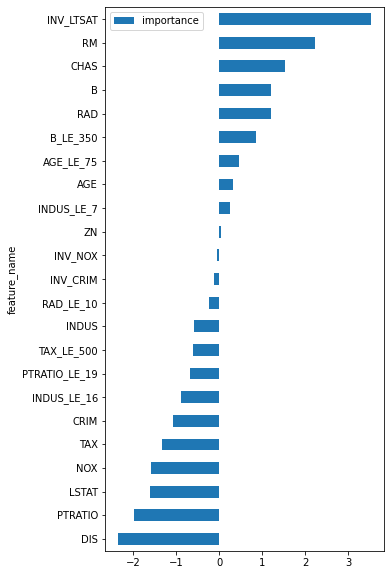

In [46]:
feat_imp_df.sort_values(by=['importance']).plot.barh(x='feature_name', y='importance', figsize=(5, 10));

### XGB regression

In [47]:
xgb_reg = Pipeline([
    ('preprocessor', allFeatureTransformers),
    ('xgb_reg', XGBRegressor())    
])

In [48]:
xgb_reg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 FeatureUnion(transformer_list=[('num',
                                                 Pipeline(steps=[('column_selector',
                                                                  ColumnSelector(columns=['CRIM',
                                                                                          'ZN',
                                                                                          'INDUS',
                                                                                          'NOX',
                                                                                          'RM',
                                                                                          'AGE',
                                                                                          'DIS',
                                                                                          'RAD',
                                                 

In [49]:
print ("R-squared: {:.2f}".format(r2_score(xgb_reg.predict(X_train), y_train)))
print ("R-squared: {:.2f}".format(r2_score(xgb_reg.predict(X_test), y_test)))

R-squared: 1.00
R-squared: 0.89


In [50]:
cv_metrics = compute_cv_metrics(xgb_reg, X, y)
print ("Mean squared error: {:.2f}".format(cv_metrics['mean_squared_error']))
print ("R2_score: {:.2f}".format(cv_metrics['R2_score']))

Mean squared error: 8.82
R2_score: 0.89


#### Feature importance

In [51]:
df_feat_imp = get_permutation_importance(xgb_reg, feature_names, X_test, y_test, n_repeats=10)
df_feat_imp

,feature_name,importance_mean,importance_std
0,LSTAT,0.760680,0.135758
1,RM,0.392628,0.035202
2,CRIM,0.102327,0.015982
3,DIS,0.099933,0.029252
4,NOX,0.084478,0.018177
5,AGE,0.046817,0.009891
6,PTRATIO,0.022030,0.005388
7,B,0.014781,0.005127
8,TAX,0.008531,0.005175
9,INDUS,0.004855,0.001606


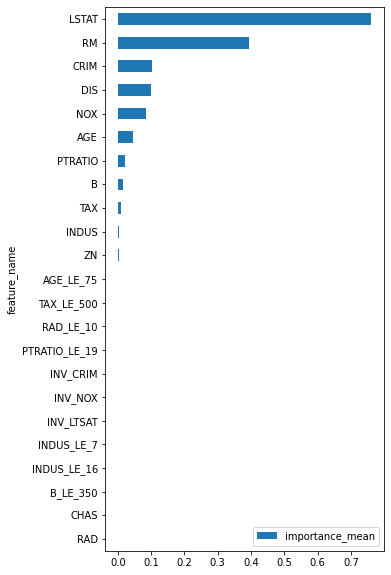

In [52]:
df_feat_imp.sort_values(by=['importance_mean']).plot.barh(x='feature_name', y='importance_mean', figsize=(5, 10));

### XGB regressor grid search

In [53]:
xgb_reg = Pipeline([
    ('preprocessor', allFeatureTransformers),
    ('xgb_reg', XGBRegressor())    
])

param_grid = {
    "xgb_reg__n_estimators": [100, 500],
    "xgb_reg__learning_rate": [0.01, 0.05, 0.1],
    "xgb_reg__max_depth": [5, 10],
    'xgb_reg__colsample_bytree': [0.2, 0.4, 0.8,]
}

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=42)
searchCV = GridSearchCV(xgb_reg, cv=cv, scoring='neg_mean_squared_error', param_grid=param_grid)
searchCV.fit(X, y)  

best_xgb_reg = searchCV.best_estimator_

In [54]:
print ("R-squared: {:.2f}".format(r2_score(best_xgb_reg.predict(X_train), y_train)))
print ("R-squared: {:.2f}".format(r2_score(best_xgb_reg.predict(X_test), y_test)))

R-squared: 1.00
R-squared: 1.00


In [55]:
cv_metrics = compute_cv_metrics(best_xgb_reg, X, y)
print ("Mean squared error: {:.2f}".format(cv_metrics['mean_squared_error']))
print ("R2_score: {:.2f}".format(cv_metrics['R2_score']))

Mean squared error: 8.41
R2_score: 0.89


#### Feature importance

In [56]:
df_feat_imp = get_permutation_importance(best_xgb_reg, feature_names, X_test, y_test, n_repeats=10)
df_feat_imp

,feature_name,importance_mean,importance_std
0,RM,4.004957e-01,3.005621e-02
1,LSTAT,3.475094e-01,6.299908e-02
2,DIS,9.608563e-02,4.416478e-02
3,NOX,6.629071e-02,1.616429e-02
4,INV_LTSAT,4.674974e-02,8.665404e-03
5,CRIM,4.212454e-02,1.418106e-02
6,PTRATIO,1.987779e-02,1.444591e-03
7,AGE,1.967137e-02,4.059423e-03
8,B,8.327063e-03,1.403893e-03
9,INDUS,6.414171e-03,9.999072e-04


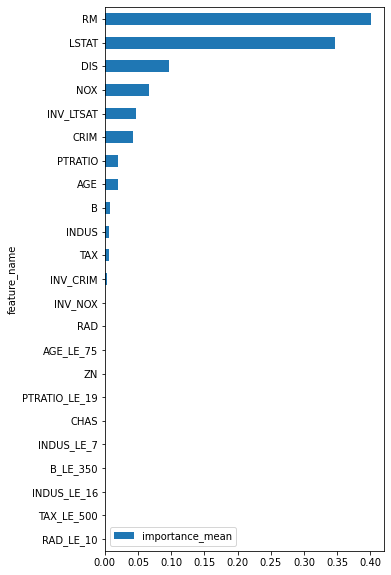

In [57]:
df_feat_imp.sort_values(by=['importance_mean']).plot.barh(x='feature_name', y='importance_mean', figsize=(5, 10));